# Multi Needle In A Haystack Evaluation + LangSmith

## Overview

To perform a multi-needle evaluation, you only need three things: 

(1) A `question` that requires multiple needles to answer

(2) an `answer` derived from the needles

(3) `list of needles` to be inserted into the context

The process follows the flow seen here:

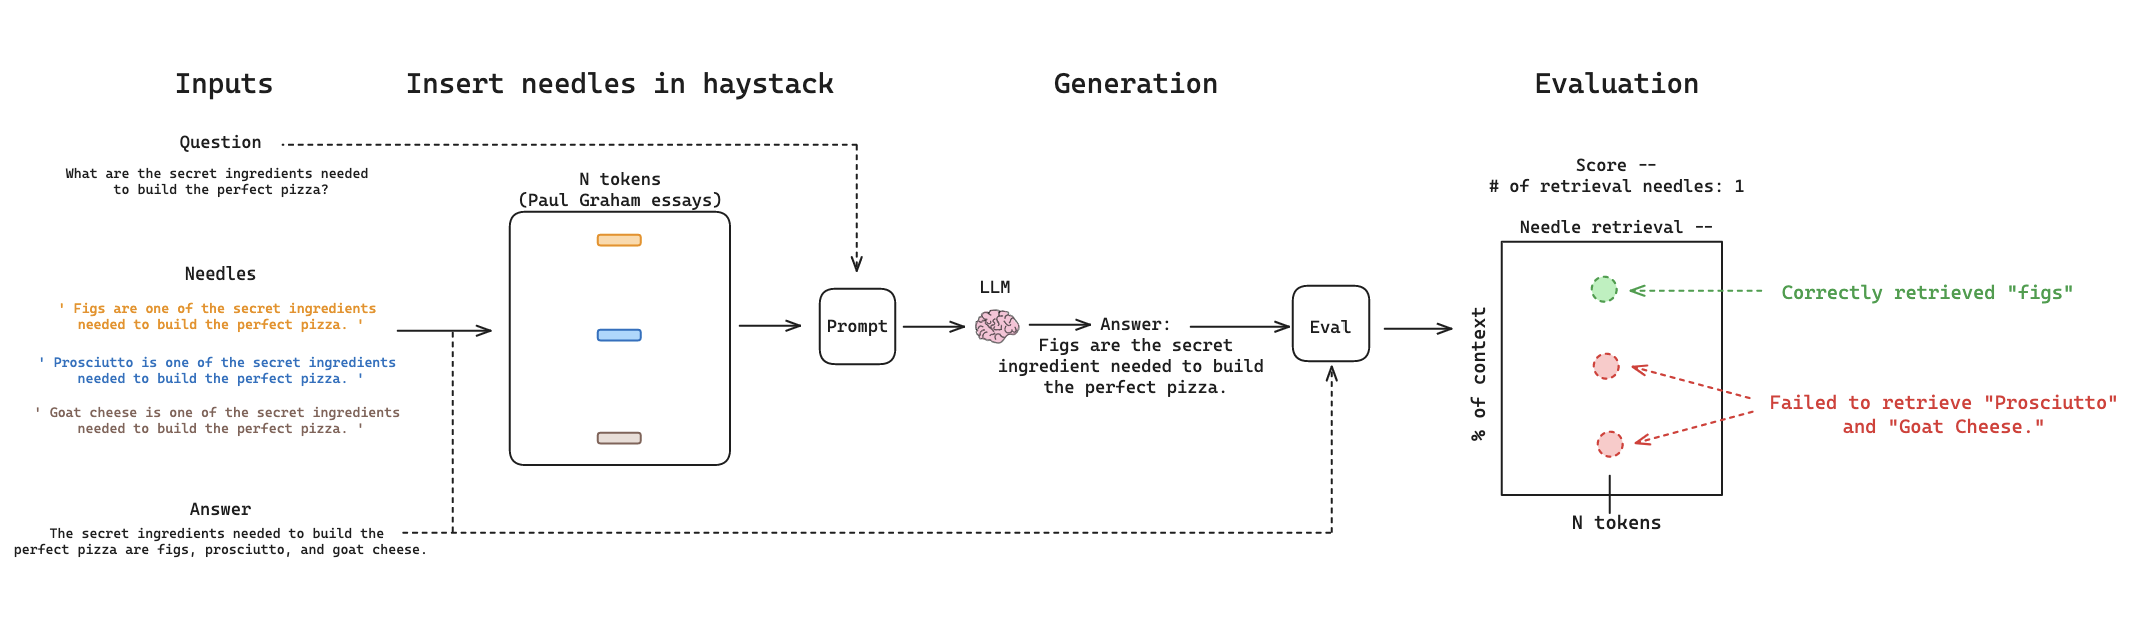

## Eval sets

Add `question` and `answer` to a LangSmith eval set.

As an example, here are the LangSmith eval sets used in this analysis.

* `multi-needle-eval-pizza-1` - https://smith.langchain.com/public/af0f1c89-3993-4ded-91c2-29eebef67582/d
* `multi-needle-eval-pizza-3` - https://smith.langchain.com/public/d6b47e6e-8279-4452-bd22-d6c8b839f1a0/d
* `multi-needle-eval-pizza-10` - https://smith.langchain.com/public/74d2af1c-333d-4a73-87bc-a837f8f0f65c/d

To simply use or inspect the resulting data generated, load the `.csv` files below in `## Load and plot retrieval data`.

## Run

See full set of commands run for this analysis [here](https://mirror-feeling-d80.notion.site/Multi-Needle-Evaluation-528e8e976a264ef3be2b145003c010e0?pvs=74).

Here is one example:

In [ ]:
! python main.py --evaluator langsmith --context_lengths_num_intervals 6 --document_depth_percent_min 50 --document_depth_percent_intervals 1 --provider openai --model_name "gpt-4-0125-preview" --multi_needle True --eval_set multi-needle-eval-pizza-1 --needles '[ " Figs are the secret ingredient needed to build the perfect pizza. " ]'  --context_lengths_min 1000 --context_lengths_max 120000

## Load results

Now, we load our resulst logged to LangSmith from each run.

In [ ]:
import os
os.environ['LANGCHAIN_TRACING_V2'] = 'true'
os.environ['LANGCHAIN_ENDPOINT'] = 'https://api.smith.langchain.com'
os.environ['LANGCHAIN_API_KEY'] = <your-api-key>

In [1]:
# Eval set names 
eval_sets_retrieval = ["multi-needle-eval-pizza-1",
                       "multi-needle-eval-pizza-3",
                       "multi-needle-eval-pizza-10"]

In [ ]:
import pandas as pd 
from langsmith.client import Client

# LangSmith client
client = Client()

def get_data(eval_sets,model):
    """    
    This function iterates through a list of evaluation sets, querying the LangSmith SDK
    for projects related to each evaluation set. It filters the projects by a specific model name,
    and compiles relevant data into a DataFrame. This includes data about run name, URL, 
    depth percentage, context length, retrieved needles, model name, total needles, answer, 
    needles, and insertion percentages.

    Parameters:
    - eval_sets (list): A list of evaluation set names to query.
    - model (str): The model name to filter the projects by.

    Returns:
    - pd.DataFrame: A DataFrame containing the compiled data from each relevant project.
    """

    # Store
    all_data = []
    
    # Iterate through eval sets 
    for set in eval_sets:

        print(f"Getting data for eval set: {set}")
    
        # All projects in a given eval set
        projects = client.list_projects(reference_dataset_name=set)
        
        # Iterate through the projects
        for p in projects:

            # Each project performs evaluation on all questions
            project = client.read_project(project_name=p.name)

            # Check that needle logging is present and filer on desired model  
            if 'needles' in project.metadata and project.metadata['model_name'] == model:

                # Get each question evaluation in our eval set
                runs = list(client.list_runs(project_id=project.id, execution_order=1))

                print(f"Getting data for run: {p.name}")

                # Get url and ensure its public
                if client.run_is_shared(run_id=runs[0].id):
                    url = client.read_run_shared_link(runs[0].id)    
                else:
                    url = client.share_run(run_id=runs[0].id)   

                # Our eval set only has 1 question, so grab the first / only row
                trace = client.get_test_results(project_name=p.name)
                generation = trace.loc[0,'outputs.output.content']
                
                # Get project metadata
                data = {
                    'run_name': project.name,
                    'run_url': url,
                    'depth %': project.metadata['depth_percent'],
                    'context length': project.metadata['context_length'],
                    'retrieved needles': project.feedback_stats['needles_retrieved']['avg'],
                    'model name': project.metadata['model_name'],
                    'total needles': project.metadata['num_needles'],
                    'answer': generation,
                    'needles': project.metadata['needles'],
                    'insertion_percentages': project.metadata['insertion_percentages']
                }
                
                # Add the data dictionary to the list
                all_data.append(data)
            
    # Convert the list of dictionaries to a DataFrame
    df = pd.DataFrame(all_data)
    return df

# Get data for each LLM
df_gpt4 = get_data(eval_sets_retrieval,"gpt-4-0125-preview")
df_anthropic = get_data(eval_sets_retrieval,"claude-3-opus-20240229")

## Check grader and get positional information for needle retrieval

We are using GPT-4 as a grader to count the number of retrieved needles in the generation versus the ground truth `answer`. 

We can check the grader by counting the needles specifically using regex. 

This is a useful check, but needs to be tuned for each eval set.

In [3]:
def count_needles(df):

    # Collect the results from all rows in df_model
    all_results = []
    
    # Iterate over each row in df
    for index, row in df.iterrows():

        # Here is relevant metadata
        needle_texts = row['needles']
        run_name = row['run_name']  
        run_url = row['run_url']  
        insertion_percentages = row['insertion_percentages']
        llm_answer = row['answer'] 
        context_size = row['context length']
        retrieved_needles = row['retrieved needles']
        total_needles = row['total needles']
        
        # ** Specific to our question ** 
        # Extract the ingredient names from each sentence in our needles
        # We will search for these ingredients in our generation as a second check
        s1 = " is one of the secret ingredients needed to build the perfect pizza."
        s2 = " are the secret ingredient needed to build the perfect pizza."
        s3 = " are one of the secret ingredients needed to build the perfect pizza."
        needle_points = [sentence.strip().strip().replace(s1, "").replace(s2, "").replace(s3, "") for sentence in needle_texts]
                
        # Check which needle points (ingredient) are in the answer
        for needle_point, insertion_percent, needle_text in zip(needle_points, insertion_percentages, needle_texts):
            present = 1 if needle_point.lower() in llm_answer.lower() else 0
            all_results.append({
                'needle': needle_text,
                'needle point': needle_point,
                'insertion %': insertion_percent,
                'context size': context_size,
                'retrieved_needles_check': present,
                'total_needles':total_needles,
                'run name': run_name,
                'run_url': run_url,
                'retrieved_needles':retrieved_needles
            })
    
    return pd.DataFrame(all_results)

# Verify results
df_gpt4_needle_check=count_needles(df_gpt4)
df_anthropic_needle_check=count_needles(df_anthropic)

Now, we can simply look for cases where the LLM grader and our manual counting differ.

We can see that this seems to happen when the number of needles is large (10).

In [ ]:
def find_traces_to_audit(df):
    
    check_df=df.groupby(['run name',
                         'retrieved_needles',
                         'total_needles'])['retrieved_needles_check'].sum().reset_index()
    
    to_audit = check_df[check_df['retrieved_needles'] != check_df['retrieved_needles_check']]
    check = [to_audit.loc[i,'run name'] for i in to_audit.index]
    print(f'Check these runs: {check}')
    return to_audit

d_fix_gpt4=find_traces_to_audit(df_gpt4_needle_check)
d_fix_anthropic=find_traces_to_audit(df_anthropic_needle_check)

Audit using LangSmith traces [here](https://smith.langchain.com/public/74d2af1c-333d-4a73-87bc-a837f8f0f65c/d?paginationState=%7B%22pageIndex%22%3A0%2C%22pageSize%22%3A50%7D&chartedColumn=latency_p50) confirms the manual check:

* `120000-5--gpt-4-0125-preview--multi-needle-eval-pizza-10--256b` -- Grader counts `espresso-soaked dates` twice. Confirm: `6`.
* `120000-5--gpt-4-0125-preview--multi-needle-eval-pizza-10--a958` -- Grader counts `espresso-soaked dates` twice. Confirm: `6`.
* `24800-5--gpt-4-0125-preview--multi-needle-eval-pizza-10--e6ae`-- Grader mistake (answer contains duplicates). Confirm: `7`.
* `48600-5--gpt-4-0125-preview--multi-needle-eval-pizza-10--12d7` -- Grader miscounts 5 as 6. Confirm: `5`.
* `190000-5--claude-3-opus-20240229--multi-needle-eval-pizza-10--40dd` --  Grader miscounts 5 as 6. Confirm: `5`.
* `190000-5--claude-3-opus-20240229--multi-needle-eval-pizza-10--590e` -- Grader miscounts 5 as 6. Confirm: `5`.
* `55000-5--claude-3-opus-20240229--multi-needle-eval-pizza-10--adfe` -- Grader miscounts 8 as 7. Confirm: `8`.
* `55000-5--claude-3-opus-20240229--multi-needle-eval-pizza-10--ce45` -- Grader miscounts 8 as 7. Confirm: `8`.
* `82000-5--claude-3-opus-20240229--multi-needle-eval-pizza-10--19e1` -- Grader miscouunts 5 as 6. Confirm: `5`.

We defer to our counting method in cases where the grader does not agree.

In [ ]:
def update_retrieved_needles(df, run_name, retrieved_needles_corrected):
    """
    Updates the 'retrieved needles' values for a specific run_name in the DataFrame.

    Parameters:
    - df: The pandas DataFrame containing the data.
    - run_name: The name of the run to update.
    - retrieved_needles_corrected: The corrected value for 'retrieved needles'.
    """
    # Check if run_name exists in the DataFrame
    if run_name in df['run_name'].values:
        # Update 'retrieved needles' where 'run_name' matches
        df.loc[df['run_name'] == run_name, 'retrieved needles'] = retrieved_needles_corrected
        print(f"Updated 'retrieved needles' for run_name '{run_name}' to {retrieved_needles_corrected}.")
    else:
        print(f"Run name '{run_name}' not found in DataFrame.")

for ix, row in d_fix_gpt4.iterrows():
    # The counts from manual check are confirmed correct
    update_retrieved_needles(df_gpt4,row['run name'],row['retrieved_needles_check'])

for ix, row in d_fix_anthropic.iterrows():
    # The counts from manual check are confirmed correct
    update_retrieved_needles(df_anthropic,row['run name'],row['retrieved_needles_check'])

In [43]:
df_gpt4.to_csv("multi-needle-datasets/gpt4_retrieval.csv")
df_anthropic.to_csv("multi-needle-datasets/anthropic_retrieval.csv")

In [44]:
df_gpt4_needle_check.to_csv("multi-needle-datasets/gpt4_retrieval_per_needle.csv")
df_anthropic_needle_check.to_csv("multi-needle-datasets/anthropic_retrieval_per_needle.csv")

## Load and plot retrieval data

If you simply want to test the below code, start here.

In [64]:
df_gpt4=pd.read_csv("multi-needle-datasets/gpt4_retrieval.csv")
df_anthropic=pd.read_csv("multi-needle-datasets/anthropic_retrieval.csv")
df_gpt4_needle_check=pd.read_csv("multi-needle-datasets/gpt4_retrieval_per_needle.csv")
df_anthropic_needle_check=pd.read_csv("multi-needle-datasets/anthropic_retrieval_per_needle.csv")

In [65]:
import ast
df_gpt4['needles'] = df_gpt4['needles'].apply(lambda x: ast.literal_eval(x))
df_anthropic['needles'] = df_anthropic['needles'].apply(lambda x: ast.literal_eval(x))
df_gpt4['insertion_percentages'] = df_gpt4['insertion_percentages'].apply(lambda x: ast.literal_eval(x))
df_anthropic['insertion_percentages'] = df_anthropic['insertion_percentages'].apply(lambda x: ast.literal_eval(x))

## Aggregate Performance

Compute fraction of retrieval needles per model, context length, and # of needles. Compute across all replicates.

In [ ]:
def plot_groups(df):

    # Group by 'context length' and 'total needles' and calculate sums
    grouped = df.groupby(['context length', 'total needles']).agg(
        sum_retrieved_needles=('retrieved needles', 'sum'),
        sum_total_needles=('total needles', 'sum')
    ).reset_index()
    
    # Calculate the fraction of retrieved needles
    grouped['frac_retrieved'] = grouped['sum_retrieved_needles'] / grouped['sum_total_needles']
    print(f"Context lengths evaluated: {df['context length'].unique()}")
    return grouped

df_gpt4_grp=plot_groups(df_gpt4)
df_anthropic_grp=plot_groups(df_anthropic)

In [67]:
# Pick min, middle, max for plotting
df_gpt4_grp = df_gpt4_grp[df_gpt4_grp['context length'].isin([1000,48600,120000])]
df_anthropic_grp = df_anthropic_grp[df_anthropic_grp['context length'].isin([1000,82000,190000])]

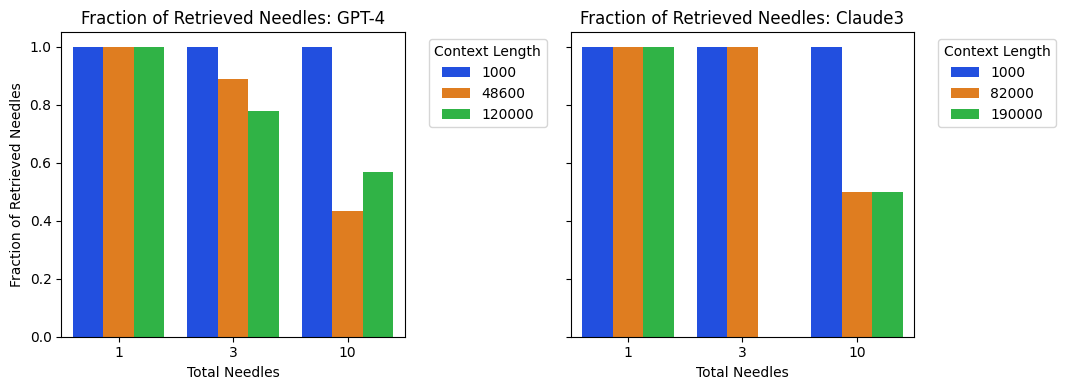

In [68]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_grouped_subplots(df_gpt4_grouped, df_claude3_grouped):
    # Create a figure with two subplots
    fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)  # Share the Y-axis
    
    # Plot for GPT-4
    sns.barplot(data=df_gpt4_grouped, 
                x='total needles', 
                y='frac_retrieved', 
                hue='context length', 
                ax=axes[0],
                palette=sns.color_palette("bright", len(df_gpt4_grouped['context length'].unique())))
    axes[0].set_title('Fraction of Retrieved Needles: GPT-4')
    axes[0].set_xlabel('Total Needles')
    axes[0].set_ylabel('Fraction of Retrieved Needles')
    axes[0].legend(title='Context Length', bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Plot for Claude3
    sns.barplot(data=df_claude3_grouped, 
                x='total needles', 
                y='frac_retrieved', 
                hue='context length', 
                ax=axes[1],
                palette=sns.color_palette("bright", len(df_claude3_grouped['context length'].unique())))
    axes[1].set_title('Fraction of Retrieved Needles: Claude3')
    axes[1].set_xlabel('Total Needles')
    # axes[1].set_ylabel('')  # You can omit the Y label for the second subplot to avoid repetition
    axes[1].legend(title='Context Length', bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Adjust layout for legend and tightness
    plt.tight_layout(rect=[0, 0, 0.9, 1])  # Adjust as needed to make room for legend
    plt.show()

# Suppress specific FutureWarnings from seaborn
import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=FutureWarning)
    # Call the plotting function with your grouped data
    plot_grouped_subplots(df_gpt4_grp, df_anthropic_grp)

## Plot retrieval wrt position 

In [69]:
# Get a single replicate to viz (1 out of 3)
replicate = 1
gpt4_replicate_1 = df_gpt4_needle_check.groupby(['context size', 'total_needles', 'insertion %']).nth(replicate).reset_index()
anthropic_replicate_1 = df_anthropic_needle_check.groupby(['context size', 'total_needles', 'insertion %']).nth(replicate).reset_index()

In [70]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.patches as mpatches

def plt_simple_needle_scatter(results_df, model, ax):
    sns.set(style="whitegrid")

    # Map 'retrieved_needles_check' to colors
    colors = results_df['retrieved_needles_check'].map({1: 'green', 0: 'red'})

    # Scatter plot without offsets for simplicity, plotted on the provided axis
    ax.scatter(results_df['context size'], results_df['insertion %'], s=100, color=colors, edgecolor='black')

    # Turn off grid lines for the axis
    ax.grid(False)
    ax.set_xlim(-2000,200000)
    ax.set_xlabel("Context Size (tokens)")
    ax.set_ylabel("Insertion % within Context")
    ax.set_title(f"Needle Retrieval Analysis: {model}")
    ax.invert_yaxis()

    # Custom legend for the axis
    green_patch = mpatches.Patch(color='green', label='Needle Retrieved')
    red_patch = mpatches.Patch(color='red', label='Needle Not Retrieved')
    ax.legend(handles=[green_patch, red_patch], loc='lower left')

The `1000 token` context can show irregularities in `Insertion %` due to:

* Needles are fairly large relative to the short context
* The insertion methods will aim to avoid sentence breaks

For `1000 token` visualization, we snap to the `Insertion %` for the next larger context length bin.

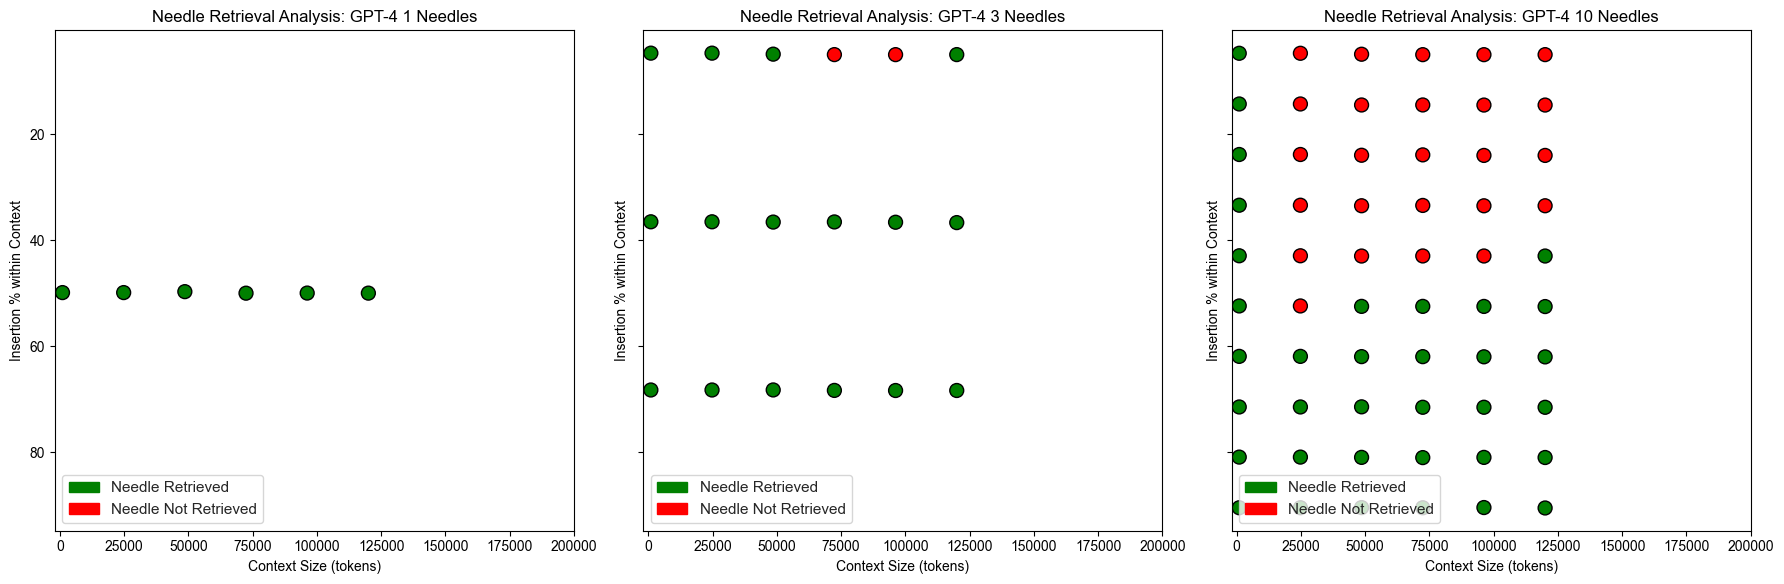

In [71]:
# Create a 1x3 subplot structure
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

# Loop through your needle counts and plot each on a subplot
needles = [1, 3, 10]
for i, n in enumerate(needles):
    
    # Isolate data 
    d = gpt4_replicate_1[gpt4_replicate_1.total_needles == n]
    # Visualization 
    context_sizes = list(reversed(d['context size'].unique()))
    insertion_percents_1000 = d[d['context size'] == context_sizes[0]]['insertion %'].unique()
    insertion_percents_next_context_increment = d[d['context size'] == context_sizes[1]]['insertion %'].unique()
    mapping_dict = dict(zip(insertion_percents_1000, insertion_percents_next_context_increment))
    rows_to_update = d['context size'] == context_sizes[0]
    d.loc[rows_to_update, 'insertion %'] = d.loc[rows_to_update, 'insertion %'].map(mapping_dict)
    # Plot
    plt_simple_needle_scatter(d, f"GPT-4 {n} Needles", axes[i])

plt.tight_layout()
plt.savefig("combined_needle_retrieval_analysis_gpt4.png", dpi=300, bbox_inches='tight')
plt.show()

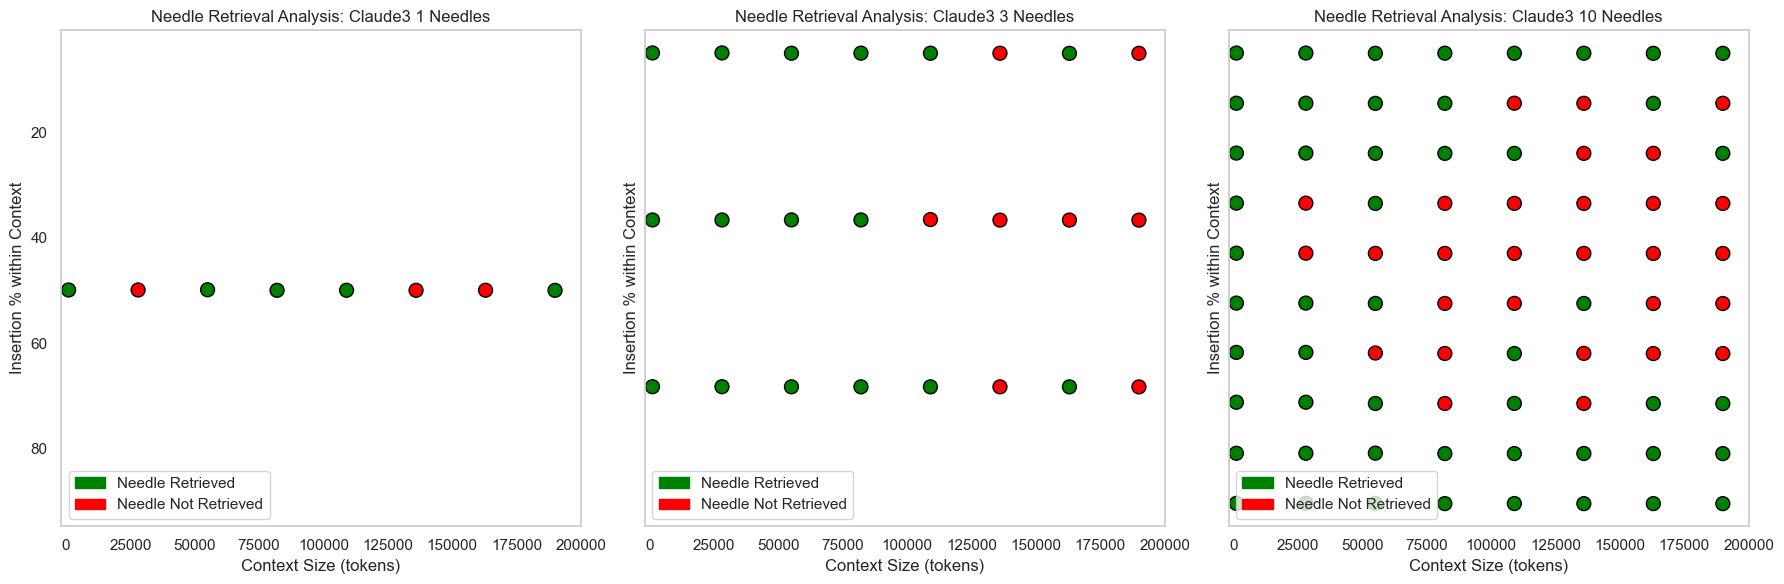

In [72]:
# Create a 1x3 subplot structure
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

# Loop through your needle counts and plot each on a subplot
needles = [1, 3, 10]
for i, n in enumerate(needles):
    # Isolate data
    d = anthropic_replicate_1[anthropic_replicate_1.total_needles == n]
    # Visualization 
    context_sizes = list(reversed(d['context size'].unique()))
    insertion_percents_1000 = d[d['context size'] == context_sizes[0]]['insertion %'].unique()
    insertion_percents_next_context_increment = d[d['context size'] == context_sizes[1]]['insertion %'].unique()
    mapping_dict = dict(zip(insertion_percents_1000, insertion_percents_next_context_increment))
    rows_to_update = d['context size'] == context_sizes[0]
    d.loc[rows_to_update, 'insertion %'] = d.loc[rows_to_update, 'insertion %'].map(mapping_dict)
    # Plot
    plt_simple_needle_scatter(d, f"Claude3 {n} Needles", axes[i])

plt.tight_layout()
plt.savefig("combined_needle_retrieval_analysis_anthropic.png", dpi=300, bbox_inches='tight')
plt.show()

## Plot retrieval vs reasoning

`eval_sets_reasoning`

* https://smith.langchain.com/public/a85db85f-ee45-4a39-a1ac-52f7279134ac/d
* https://smith.langchain.com/public/270cd9cd-154d-4ba9-8b34-7b6537007867/d
* https://smith.langchain.com/public/00658b64-6199-48fc-9443-1478aadbe19a/d

In [73]:
# Here is a csv of the data
df_gpt4_reasoning=pd.read_csv("multi-needle-datasets/gpt4_reasoning.csv")

In [ ]:
# Manual audit of grader
update_retrieved_needles(df_gpt4_reasoning,'120000-5--gpt-4-0125-preview--multi-needle-eval-pizza-reasoning-10--e759',7)
update_retrieved_needles(df_gpt4_reasoning,'120000-5--gpt-4-0125-preview--multi-needle-eval-pizza-reasoning-10--9db6',5)
update_retrieved_needles(df_gpt4_reasoning,'120000-5--gpt-4-0125-preview--multi-needle-eval-pizza-reasoning-10--04e6',5)

In [ ]:
df_gpt4_grp_reasoning=plot_groups(df_gpt4_reasoning)

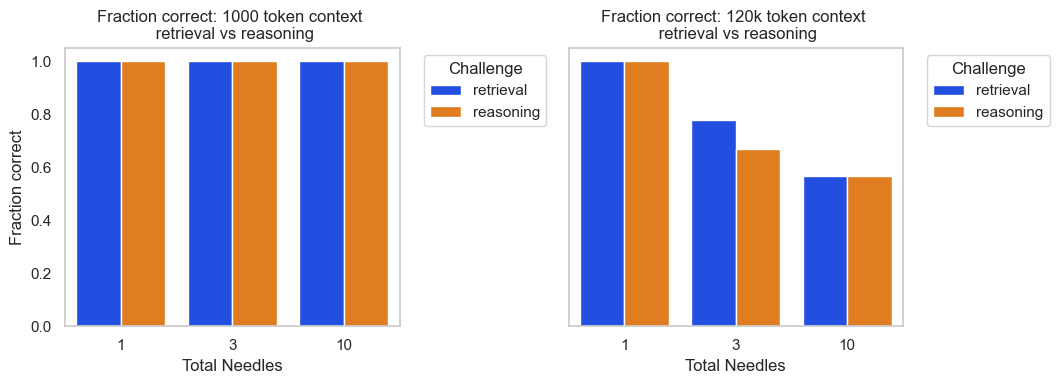

In [82]:
def plot_grouped_subplots(df_1000,df_120k):
    # Create a figure with two subplots
    fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)  # Share the Y-axis
    
    # Plot
    sns.barplot(data=df_1000, 
                x='total needles', 
                y='frac_retrieved', 
                hue='mode', 
                ax=axes[0],
                palette=sns.color_palette("bright", len(df_1000['mode'].unique())))
    axes[0].set_title('Fraction correct: 1000 token context \n retrieval vs reasoning')
    axes[0].set_xlabel('Total Needles')
    axes[0].set_ylabel('Fraction correct')
    axes[0].legend(title='Challenge', bbox_to_anchor=(1.05, 1), loc='upper left')
    axes[0].grid(False)
    
     # Plot
    sns.barplot(data=df_120k, 
                x='total needles', 
                y='frac_retrieved', 
                hue='mode', 
                ax=axes[1],
                palette=sns.color_palette("bright", len(df_120k['mode'].unique())))
    axes[1].set_title('Fraction correct: 120k token context \n retrieval vs reasoning')
    axes[1].set_xlabel('Total Needles')
    axes[1].set_ylabel('Fraction correct')
    axes[1].legend(title='Challenge', bbox_to_anchor=(1.05, 1), loc='upper left')
    axes[1].grid(False)

    # Adjust layout for legend and tightness
    plt.tight_layout(rect=[0, 0, 0.9, 1])  # Adjust as needed to make room for legend
    plt.show()

# Combine
df_gpt4_grp_retrieval = df_gpt4_grp.copy()
df_gpt4_grp_retrieval['mode'] = 'retrieval'
df_gpt4_grp_reasoning['mode'] = 'reasoning'
combined = pd.concat([df_gpt4_grp_retrieval,df_gpt4_grp_reasoning],axis=0)

# Suppress specific FutureWarnings from seaborn
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=FutureWarning)
    plot_grouped_subplots(combined[combined['context length']==1000],
                          combined[combined['context length']==120000])